## Resolution: 224x224

In [ ]:
## GramCam (batch size 32, dropout rate 0.3, no attention layer, no class-weighted loss, Adam(1e-4))

In [1]:
import matplotlib as mpl
import numpy as np
import tensorflow as tf
import os
from tensorflow import keras
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from PIL import Image 

2025-04-29 00:11:41.856700: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745899901.876645   32623 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745899901.882577   32623 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1745899901.897783   32623 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745899901.897817   32623 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1745899901.897820   32623 computation_placer.cc:177] computation placer alr

In [3]:
## ResNet50_224
model_50_224 = load_model('model_output/ResNet50_224.keras', compile=False)

In [4]:
# 1) model details
model = model_50_224  
img_size = (224,224)  
preprocess_input = lambda x: x / 255.0  

In [6]:
# 2) find last conv layer name 
# model.summary()  # find the last conv layer
last_conv_layer_name = "conv5_block3_out" 

In [7]:
# 3) Prepare image function
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# 4) GradCam function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 5) Plot + Save function
def save_and_display_gradcam(img_path, heatmap, save_dir="gradcam_outputs/ResNet50_224", alpha=0.4):
   
    os.makedirs(save_dir, exist_ok=True)

    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    img_filename = os.path.basename(img_path) # image path base name (no directory part)
    img_name_no_ext = os.path.splitext(img_filename)[0] # remove ".jpg"
    cam_filename = f"{img_name_no_ext}_gradcam.jpg"

    full_path = os.path.join(save_dir, cam_filename)

    superimposed_img.save(full_path)

    display(Image.open(full_path))

In [ ]:
# label_dict = {
#     "0": "neutrophil",
#     "1": "eosinophil",
#     "2": "basophil",
#     "3": "lymphocyte",
#     "4": "monocyte",
#     "5": "immature granulocyte",
#     "6": "erythroblast",
#     "7": "platelet"
# }

In [33]:
!ls ./image/224

basophil_test_64.jpg		   lymphocyte_test_64.jpg
eosinophil_test_64.jpg		   monocyte_test_64.jpg
erythroblast_test_64.jpg	   neutrophil_test_64.jpg
immature_granulocytes_test_64.jpg  platelet_test_64.jpg


Predicted class: 0


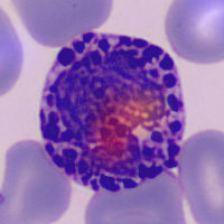

In [9]:
# 6) RUN Grad-CAM on image
img_path = "./image/224/basophil_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 4


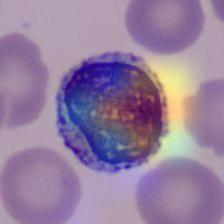

In [10]:
img_path = "./image/224/lymphocyte_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 1


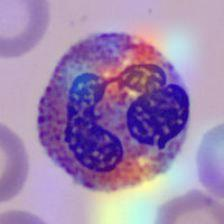

In [11]:
img_path = "./image/224/eosinophil_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 5


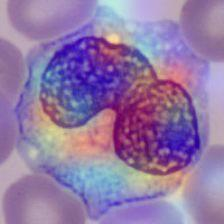

In [12]:
img_path = "./image/224/monocyte_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 2


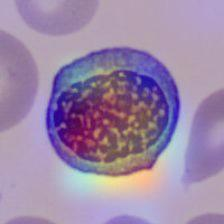

In [13]:
# 6) RUN Grad-CAM on image
img_path = "./image/224/erythroblast_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 5


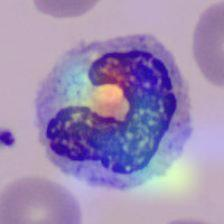

In [14]:
# 6) RUN Grad-CAM on image
img_path = "./image/224/neutrophil_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 3


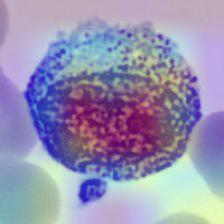

In [15]:
# 6) RUN Grad-CAM on image
img_path = "./image/224/immature_granulocytes_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 7


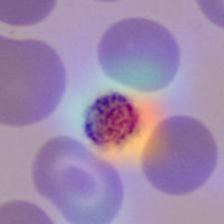

In [16]:
# 6) RUN Grad-CAM on image
img_path = "./image/224/platelet_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

In [ ]:
######## IGNORE FOR NOW! HAVEN'T RUN ########

In [ ]:
## ResNet101_224
model_101_224 = load_model('model_output/ResNet101_224.keras', compile=True)

In [15]:
# 1) model details
model = model_101_224  
img_size = (224,224)  
preprocess_input = lambda x: x / 255.0  

In [24]:
# 2) find last conv layer name 
# model.summary()  # find the last conv layer
last_conv_layer_name = "conv5_block3_out" 

In [25]:
# 3) Prepare image function
def get_img_array(img_path, size):
    img = keras.utils.load_img(img_path, target_size=size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

# 4) GradCam function
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    grad_model = keras.models.Model(
        [model.inputs], 
        [model.get_layer(last_conv_layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    grads = tape.gradient(class_channel, last_conv_layer_output)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()

# 5) Plot + Save function
def save_and_display_gradcam(img_path, heatmap, save_dir="gradcam_outputs/ResNet101_224", alpha=0.4):
   
    os.makedirs(save_dir, exist_ok=True)

    img = keras.utils.load_img(img_path)
    img = keras.utils.img_to_array(img)
    
    heatmap = np.uint8(255 * heatmap)
    jet = mpl.colormaps['jet']
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]
    jet_heatmap = keras.utils.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((img.shape[1], img.shape[0]))
    jet_heatmap = keras.utils.img_to_array(jet_heatmap)

    superimposed_img = jet_heatmap * alpha + img
    superimposed_img = keras.utils.array_to_img(superimposed_img)

    img_filename = os.path.basename(img_path) # image path base name (no directory part)
    img_name_no_ext = os.path.splitext(img_filename)[0] # remove ".jpg"
    cam_filename = f"{img_name_no_ext}_gradcam.jpg"

    full_path = os.path.join(save_dir, cam_filename)

    superimposed_img.save(full_path)

    display(Image.open(full_path))

In [ ]:
# label_dict = {
#     "0": "neutrophil",
#     "1": "eosinophil",
#     "2": "basophil",
#     "3": "lymphocyte",
#     "4": "monocyte",
#     "5": "immature granulocyte",
#     "6": "erythroblast",
#     "7": "platelet"
# }

In [33]:
!ls ./image/224

basophil_test_64.jpg		   lymphocyte_test_64.jpg
eosinophil_test_64.jpg		   monocyte_test_64.jpg
erythroblast_test_64.jpg	   neutrophil_test_64.jpg
immature_granulocytes_test_64.jpg  platelet_test_64.jpg


Predicted class: 0


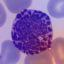

In [27]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/224/basophil_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 4


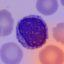

In [32]:
img_path = "/shared/home/tzj255/bmi707_fp/image/224/lymphocyte_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 1


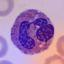

In [34]:
img_path = "/shared/home/tzj255/bmi707_fp/image/224/eosinophil_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 5


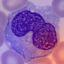

In [35]:
img_path = "/shared/home/tzj255/bmi707_fp/image/224/monocyte_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 3


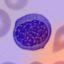

In [36]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/224/erythroblast_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 6


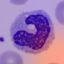

In [37]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/224/neutrophil_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 3


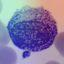

In [38]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/224/immature_granulocytes_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)

Predicted class: 7


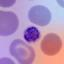

In [39]:
# 6) RUN Grad-CAM on image
img_path = "/shared/home/tzj255/bmi707_fp/image/224/platelet_test_224.jpg" 
img_array = preprocess_input(get_img_array(img_path, size=img_size))

# predict class
img_tensor = tf.convert_to_tensor(img_array)
preds = model(img_tensor, training=False)
print("Predicted class:", np.argmax(preds[0]))

# generate heatmap
heatmap = make_gradcam_heatmap(img_array, model, last_conv_layer_name)

# save and display
save_and_display_gradcam(img_path, heatmap)